# Контекст

- Прогнозирование тональности рецензий на фильмы IMDb
- Будет использована многоуровневая RNN архитектура «многие к одному». 

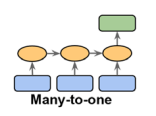

# Импорты

In [110]:
# база
import pandas as pd
import numpy as np
import re

# sklearn
from sklearn.model_selection import train_test_split


# torch
import torch
import torch.nn as nn
from torchtext.vocab import Vocab
from torch.utils.data import DataLoader, Dataset

# collections
from collections import Counter, OrderedDict



# константа
RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Чтение

In [111]:
train = pd.read_csv('train.csv')
train.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [113]:
train.sentiment.value_counts()

sentiment
neg    12500
pos    12500
Name: count, dtype: int64

# Разбиваем на тренировочный и валидационный

In [114]:
train, val = train_test_split(
    train,
    test_size = 0.2,
    stratify = train['sentiment'],
    random_state = RANDOM_STATE
)

len(train), len(val)

(20000, 5000)

# Поиск уникальных лексем

## Функция обработки текста

In [115]:
def tokenizer(text):
    '''  
    возвращает список токенов строки
    '''
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized

## Подсчет уникальных токенов во всем тренировочном датасете

In [116]:
token_counts = Counter()
for stroka in train['text']:
    tokens = tokenizer(stroka)
    token_counts.update(tokens)

In [117]:
len(dict(token_counts))

69122

## Создаем словарь

In [118]:
vocab = Vocab(token_counts, specials = ['<pad>', '<unk>'])
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000002003E0C0040>>,
            {'<pad>': 0,
             '<unk>': 1,
             'the': 2,
             'and': 3,
             'a': 4,
             'of': 5,
             'to': 6,
             'is': 7,
             'it': 8,
             'in': 9,
             'i': 10,
             'this': 11,
             'that': 12,
             's': 13,
             'was': 14,
             'as': 15,
             'for': 16,
             'movie': 17,
             'with': 18,
             'but': 19,
             'film': 20,
             't': 21,
             'you': 22,
             'on': 23,
             'not': 24,
             'he': 25,
             'his': 26,
             'are': 27,
             'have': 28,
             'be': 29,
             'one': 30,
             'all': 31,
             'at': 32,
             'they': 33,
             'by': 34,
             'an': 35,
             'who': 36,
             'so': 37

### Пример использования словаря

In [119]:
[vocab[token] for token in 'this is an example durachok and useless noobic like Dima'.split()]

[11, 7, 35, 460, 1, 3, 3415, 1, 39, 1]

# Пайплайны обработки текста и меток в целочисленные выражения

In [120]:
text_pipeline = \
    lambda x: [vocab[token] for token in tokenizer(x)]

label_pipeline = \
    lambda x: 1. if x == 'pos' else 0

# Создаем Dataset - Dataloader

In [121]:
class IMDBDataset(Dataset):
    def __init__(self, df):
        """
        Args:
            df (pandas.DataFrame): датасет
        """
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        return row.sentiment, row.text

In [122]:
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    
    return padded_text_list, label_list, lengths

# Dataloader
train_dataloader = DataLoader(
    dataset = IMDBDataset(train),
    batch_size = 4,
    shuffle=False,
    collate_fn = collate_batch
    )

## Опробуем Dataloader

In [123]:
values, labels, lengths = next(iter(train_dataloader))
values

tensor([[ 60, 190,   4,  ...,   0,   0,   0],
        [ 11,  14,   2,  ...,  67, 889, 463],
        [  4, 549,   5,  ...,   0,   0,   0],
        [ 11,  17, 856,  ...,   0,   0,   0]])

In [124]:
labels

tensor([1., 0., 1., 1.])

In [125]:
lengths

tensor([224, 369, 267,  99])

In [126]:
values.shape

torch.Size([4, 369])

# Dataloaders

In [127]:
train_dataloader = DataLoader(
    dataset = IMDBDataset(train),
    batch_size = 32,
    shuffle=True,
    collate_fn = collate_batch
    )

val_dataloader = DataLoader(
    dataset = IMDBDataset(val),
    batch_size = 32,
    shuffle=False,
    collate_fn = collate_batch
    )

test_dataloader = DataLoader(
    dataset = IMDBDataset(pd.read_csv('test.csv')),
    batch_size = 32,
    shuffle=False,
    collate_fn = collate_batch
    )

# Model

In [128]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      embed_dim,
                                      padding_idx=0)
        
        self.rnn = nn.LSTM(embed_dim,
                           rnn_hidden_size,
                           batch_first=True)
        
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out,
                                                lengths.cpu().numpy(),
                                                enforce_sorted=False,
                                                batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out


# Начальные данные для модели

In [129]:
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

model = RNN(
    vocab_size,
    embed_dim,
    rnn_hidden_size,
    fc_hidden_size
)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCELoss()

model = model.to(device)

# Training loop

In [130]:
def train(train_dataloader):
    
    model.train()

    total_acc = 0
    total_loss = 0

    for text_batch, label_batch, lengths in train_dataloader:
        optimizer.zero_grad()

        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)

        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)

        loss.backward()
        optimizer.step()

        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(train_dataloader.dataset),\
           total_loss/len(train_dataloader.dataset)



def evaluate(dataloader):

    model.eval()
    total_acc, total_loss = 0, 0

    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:

            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)

            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)

            total_acc += ((pred>=0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset),\
           total_loss/len(dataloader.dataset)


def loop(
    # loop settings
    num_epoches        
        ):
    
    for epoch in range(1, num_epoches+1):

        acc_train, loss_train = train(train_dataloader)
        acc_val, loss_val = evaluate(val_dataloader)

        print('Epoch {:5}/{:5} || train loss: {:.3f} || val_loss: {:.3f} || train accuracy: {:.3f} || val accuracy: {:.3f}'
                        .format(epoch,
                                num_epoches,
                                loss_train,
                                loss_val,
                                acc_train,
                                acc_val))    

# Тренировка

In [131]:
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.BCELoss()


loop(10)


Epoch     1/   10 || train loss: 0.653 || val_loss: 0.617 || train accuracy: 0.611 || val accuracy: 0.646
Epoch     2/   10 || train loss: 0.527 || val_loss: 0.510 || train accuracy: 0.742 || val accuracy: 0.757
Epoch     3/   10 || train loss: 0.410 || val_loss: 0.438 || train accuracy: 0.817 || val accuracy: 0.788
Epoch     4/   10 || train loss: 0.341 || val_loss: 0.403 || train accuracy: 0.861 || val accuracy: 0.819
Epoch     5/   10 || train loss: 0.401 || val_loss: 0.540 || train accuracy: 0.819 || val accuracy: 0.758
Epoch     6/   10 || train loss: 0.377 || val_loss: 0.385 || train accuracy: 0.833 || val accuracy: 0.837
Epoch     7/   10 || train loss: 0.254 || val_loss: 0.369 || train accuracy: 0.902 || val accuracy: 0.847
Epoch     8/   10 || train loss: 0.191 || val_loss: 0.399 || train accuracy: 0.929 || val accuracy: 0.847
Epoch     9/   10 || train loss: 0.155 || val_loss: 0.387 || train accuracy: 0.944 || val accuracy: 0.853
Epoch    10/   10 || train loss: 0.124 || val_

# Проверка на тестовых данных

In [132]:
acc_test, _ = evaluate(test_dataloader)
acc_test

0.83332